### Import the libraries

In [1]:
import cv2
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import datetime
from glob import glob
import os
import exifread
import scipy.ndimage.interpolation
from pysolar.solar import *
import scipy.io

import matplotlib as mpl
mpl.style.use('classic')
mpl.rc("figure", facecolor="white")

# User defined functions
from normalize_array import *

### MODIS data

This section loads the pre-computed COT values from MODIS satellite images. It is done via the MATLAB function *something.m*. It computes the stores MOD and MYD data for the year 2015. The various parameters are day number, time, and the average COT value. 

In [2]:
file_path1a = "./COT/MOD2015_DOY.txt"
file_path2a = "./COT/MOD2015_Time.txt"
file_path3a = "./COT/MOD2015_AvgCOT.txt"

file_path1b = "./COT/MYD2015_DOY.txt"
file_path2b = "./COT/MYD2015_Time.txt"
file_path3b = "./COT/MYD2015_AvgCOT.txt"

### Reading the MODIS data into individual dictionaries 

In [3]:
input_file1a = csv.DictReader(open(file_path1a), fieldnames = ["DOY"])
input_file2a = csv.DictReader(open(file_path2a), fieldnames = ["Time"])
input_file3a = csv.DictReader(open(file_path3a), fieldnames = ["COT"])

input_file1b = csv.DictReader(open(file_path1b), fieldnames = ["DOY"])
input_file2b = csv.DictReader(open(file_path2b), fieldnames = ["Time"])
input_file3b = csv.DictReader(open(file_path3b), fieldnames = ["COT"])

### Accessing the MOD data

In [4]:
MOD_DOY = []
MOD_date = []
MOD_time = []
MOD_COT = []

for i,row in enumerate(input_file1a):
    DOY_item = int(row["DOY"])
    date_object = datetime.datetime(2015, 1, 1) + datetime.timedelta(DOY_item - 1)
    date_item = str(date_object.year)+'-'+str(date_object.month)+'-'+str(date_object.day)
    
    MOD_DOY.append(DOY_item)
    MOD_date.append(date_item)
    
    
for row in input_file2a:
    time_item = row["Time"]
    time_item = time_item[5:-1]
    MOD_time.append(time_item)
    
    
for row in input_file3a:
    cot_item = float(row["COT"])
    MOD_COT.append(cot_item)

### Accessing the MYD data

In [5]:
MYD_DOY = []
MYD_date = []
MYD_time = []
MYD_COT = []

for i,row in enumerate(input_file1b):
    DOY_item = int(row["DOY"])
    date_object = datetime.datetime(2015, 1, 1) + datetime.timedelta(DOY_item - 1)
    date_item = str(date_object.year)+'-'+str(date_object.month)+'-'+str(date_object.day)
    
    MYD_DOY.append(DOY_item)
    MYD_date.append(date_item)
    
    
for row in input_file2b:
    time_item = row["Time"]
    time_item = time_item[5:-1]
    MYD_time.append(time_item)
    
    
for row in input_file3b:
    cot_item = float(row["COT"])
    MYD_COT.append(cot_item)

### Combining the MOD and MYD data into a combined COT file

In [6]:
file_name = './COT/combined/COT2015.txt'
text_file = open(file_name, "w")

# Header line
text_file.write("DayNumber,Date,Time,COT\n") 

for i,item in enumerate(MOD_DOY):
    text_file.write("%d,%s,%s,%s\n" %(item, MOD_date[i], MOD_time[i], MOD_COT[i]))
    
for i,item in enumerate(MYD_DOY):
    text_file.write("%d,%s,%s,%s\n" %(item, MYD_date[i], MYD_time[i], MYD_COT[i]))
    
text_file.close()

### Luminance from sky cameras

We compute the average luminance value of all the ground-based sky camera images, that are within +/- 15 minutes of the MODIS image timestamp. This luminance pre-computation is done using the python script *calculate_luminance.py*. It uses various helper functions viz. *cmask.py*, *find_sun.py*, *nearest.py*, *SG_solarmodel.py* to compute the average luminance.

Please refer the Git repository <a href="https://github.com/Soumyabrata/solar-irradiance-estimation">solar-irradiance-estimation</a> for more extensive details on luminance calculation from sky camera images. 

The following section reads the average luminance file, and populates the corresponding COT value for further analysis.

In [7]:
# average value of 3X3 COT values, and average luminance between +-15 mins
CSV_file = './average_luminance/2015data.txt'

with open(CSV_file) as f: #f is a file header
    reader = csv.reader(f, delimiter=",")
    d = list(reader) # d is a list of list here.
    
LuminanceAll = []
COTAll = []
CSRAll = []
CSLAll = []
TimeAll = []

for item in d[1:]:
    ImageTime = item[1]
    MODISTime = item[2]
    Luminance = float(item[3])
    COT = float(item[4])
    CSR = float(item[5])
    CSL = float(item[6])
    
    LuminanceAll.append(Luminance)
    COTAll.append(COT)
    CSRAll.append(CSR)
    CSLAll.append(CSL)
    
    #Find the datetime object
    TimeObject = ImageTime.split(" ")
    DatePart = TimeObject[0]
    DP = DatePart.split("-")
    YY = DP[0]
    MM = DP[1]
    DD = DP[2]
    
    TimePart = TimeObject[1]
    TP = TimePart.split(":")
    HH = TP[0]
    MINT = TP[1]
    SEC = TP[2]
    time_now = datetime.datetime(int(YY),int(MM),int(DD),int(HH),int(MINT),int(SEC))
    TimeAll.append(time_now)
    
print ('The total number of common observations of luminance and COT is', len(COTAll))

The total number of common observations of luminance and COT is 199


### Computing the luminance difference

In [8]:
COT_values = COTAll
luminance_diff = np.abs((np.array(CSLAll)) - (np.array(LuminanceAll)))

### Pre-processing the data

There might be a few spurious data in the data sample, and therefore we need to pre-process them. The maximum allowable value for COT is 100. In case, there are any samples that are greater than 100, we truncate them back to 100. We also remove *nans* from luminance difference data points. We also reject outliers.

In [11]:
#Any COT above 100, truncate it to 100
COTAll = np.asarray(COTAll)
h_index = np.where(COTAll > 100)
h_index = h_index[0]
COTAll[h_index] = 100

# Removing nans
indexes = ~np.isnan(luminance_diff)
luminance_diff = luminance_diff[indexes]
COT_values = np.array(COT_values)
COT_values = COT_values[indexes]

# Removing outlier points
del_index = np.where( np.array(luminance_diff) > 400000 )
COT_values = np.delete(COT_values, del_index)
luminance_diff = np.delete(luminance_diff, del_index)
TimeAll = np.delete(TimeAll, del_index)

print ('Data cleaned.')

Data cleaned.


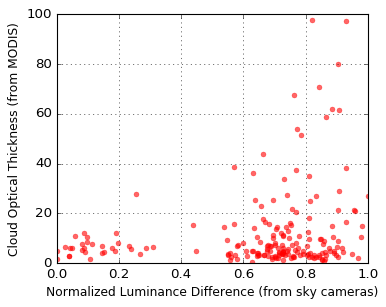

In [12]:
fig = plt.figure(1,figsize=(5, 4)) 
plt.scatter( normalize_array(luminance_diff), COT_values, marker='o' , linewidths=0.4 , alpha = 0.6 , color = 'r')
plt.xlabel('Normalized Luminance Difference (from sky cameras)', fontsize=11)
plt.ylabel('Cloud Optical Thickness (from MODIS)', fontsize=11)
plt.grid(b=None, which='major', axis='both')
plt.xlim((0,1))
plt.ylim((0,100))
plt.tight_layout()
plt.savefig('./figs/COT.pdf', format='pdf')
plt.show()